In [1]:
import os

import librosa
import numpy as np
from scipy.io import wavfile
from tqdm.notebook import tqdm

from text import _clean_text

import yaml
import joblib
from joblib import Parallel, delayed
from dask.distributed import Client

client = Client()

In [8]:
from glob import glob
import json
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
pitch_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/pitch/*.npy"
duration_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/duration/*.npy"
energy_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/energy/*.npy"
stats_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/stats.json"

In [10]:
train_file = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/train.txt"
val_file = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/val.txt"

In [17]:
train_df = pd.read_csv(train_file,header=None, delimiter="|")
train_df.columns = ["fname", "speaker_id", "phones", "text"]
train_df["phones"] = train_df["phones"].apply(lambda x: x.lstrip("{"))
train_df["phones"] = train_df["phones"].apply(lambda x: x.rstrip("}"))
train_df.head()

,fname,speaker_id,phones,text
0,CB-JE-13-89,CB,F AO1 R SH IY1 S EH1 Z Y UW1 HH AE1 V AO1 L W ...,for she says you have always been in the habit...
1,CB-EM-41-110,CB,DH EY1 W ER0 R AE1 P AH0 D L IY0 F AO1 R M IH0...,they were rapidly forming words for each other...
2,CB-EM-43-258,CB,B AH1 T AY1 M AH1 S T AY1 W IH1 L spn W IH1 L ...,"but i must, i will,--i will tell you truths wh..."
3,CB-JE-37-04,CB,HH IH1 Z F AA1 DH ER0 HH AE1 D P ER1 CH AH0 S ...,his father had purchased the estate for the sa...
4,CB-EM-54-134,CB,AY1 HH AE1 V AO1 F AH0 N T AO1 K T T UW1 HH ER...,i have often talked to her a good deal.


In [18]:
val_df = pd.read_csv(val_file,header=None, delimiter="|")
val_df.columns = ["fname", "speaker_id", "phones", "text"]
val_df["phones"] = val_df["phones"].apply(lambda x: x.lstrip("{"))
val_df["phones"] = val_df["phones"].apply(lambda x: x.rstrip("}"))
val_df.head()

,fname,speaker_id,phones,text
0,CB-LCL-16-721,CB,B ER1 N IH0 NG AW1 T DH AH0 SH EY1 M Z DH AH0 ...,"burning out the shames, the deepest, oldest sh..."
1,CB-FFM-43-99,CB,W IH0 DH AH0 S W OW1 L AH0 N HH AA1 R T SH IY1...,with a swollen heart she went again up the lan...
2,CB-JE-19-39,CB,Y UW1 AA1 R S IH1 L IY0 B IH0 K AH1 Z S AH1 F ...,"you are silly, because, suffer as you may, you..."
3,CB-LCL-17-490,CB,AY1 AE1 S K T HH IH1 M IH1 F IH1 T W AH1 Z T R...,i asked him if it was true that he entertained...
4,CB-LCL-12-203,CB,AE1 T Y UH1 R L EY1 D IY0 SH IH2 P S S ER1 V A...,"at your ladyship's service,' he replied."


In [22]:
x = f"/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/pitch/CB-pitch-{'CB-FFM-43-99'}.npy"
pitch = np.load(x)

In [24]:
len(pitch)

46

In [33]:
len(val_df[val_df["fname"] == "CB-FFM-43-99"].phones.values[0].split(" ")

46

In [52]:
from collections import defaultdict

PHONES = {"energy": defaultdict(list), "pitch": defaultdict(list), "duration": defaultdict(list)}

with open(stats_path) as f:
    stats = json.load(f)
    
def build_phone_stats(df):
    for t in tqdm(["energy", "pitch", "duration"], total=3, desc="predictor:>"):
        for i, r in tqdm(df.iterrows(), total=len(df), desc="traind_df:>"):
            path = f"/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/{t}/CB-{t}-{r['fname']}.npy"
            val = list(np.load(path))
            phones = r["phones"].split(" ")
            assert len(val) == len(phones)
            for x, y in zip(phones, val):
                if t in ["energy", "pitch"]:
                    PHONES[t][x].append(y*stats[t][3] + stats[t][2])
                else:
                    PHONES[t][x].append(y)

In [53]:
build_phone_stats(val_df)

predictor:>:   0%|          | 0/3 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/512 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/512 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/512 [00:00<?, ?it/s]

In [54]:
build_phone_stats(train_df)

predictor:>:   0%|          | 0/3 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/39448 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/39448 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/39448 [00:00<?, ?it/s]

In [61]:
PHONE_STATS = {"energy": defaultdict(dict), "pitch": defaultdict(dict), "duration": defaultdict(dict)}
for k, v in PHONES.items():
    for phone, vals in v.items():
        PHONE_STATS[k][phone]["mean"] = float(np.mean(vals))
        PHONE_STATS[k][phone]["std"] = float(np.std(vals))
        PHONE_STATS[k][phone]["min"] = float(np.min(vals))
        PHONE_STATS[k][phone]["max"] = float(np.max(vals))

In [62]:
PHONE_STATS

{'energy': defaultdict(dict,
             {'B': {'mean': 37.98926236779475,
               'std': 33.76641258569876,
               'min': 5.24914817390254e-07,
               'max': 272.67652580859277},
              'ER1': {'mean': 66.33731879467791,
               'std': 40.105990671082445,
               'min': 5.24914817390254e-07,
               'max': 245.7462624592873},
              'N': {'mean': 71.14280114917975,
               'std': 47.66338932500163,
               'min': 5.24914817390254e-07,
               'max': 296.8745193935317},
              'IH0': {'mean': 56.75309237293201,
               'std': 36.9925178934525,
               'min': 5.24914817390254e-07,
               'max': 285.0603253677361},
              'NG': {'mean': 68.22344024595714,
               'std': 41.398029513020894,
               'min': 5.24914817390254e-07,
               'max': 264.45102562199594},
              'AW1': {'mean': 70.59393730907716,
               'std': 39.77295653331282,
   

In [64]:
with open("/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/phone_stats.json", "w") as f:
    json.dump(PHONE_STATS, f, indent=4)

In [ ]:

# Word level

In [78]:
pitch_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/pitch/*.npy"
duration_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/duration/*.npy"
energy_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/energy/*.npy"
stats_path = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/stats.json"

In [79]:
train_file = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/train.txt"
val_file = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/val.txt"

In [81]:
train_df = pd.read_csv(train_file,header=None, delimiter="|")
train_df.columns = ["fname", "speaker_id", "words", "text"]
train_df["words"] = train_df["words"].apply(lambda x: x.lstrip("{"))
train_df["words"] = train_df["words"].apply(lambda x: x.rstrip("}"))
train_df.head()

,fname,speaker_id,words,text
0,CB-LCL-19-420,CB,i sometimes sit in the wellington and talk to ...,i sometimes sit in the wellington and talk to ...
1,CB-FFM-10-81,CB,well enough but a poor gawkhammer mortal the w...,"well enough, but a poor gawkhammer mortal, the..."
2,CB-JE-14-156,CB,that is no answer,that is no answer;
3,CB-EM-10-02,CB,and on the morrow emma had a charitable visit ...,"and on the morrow, emma had a charitable visit..."
4,CB-EM-23-10,CB,she came solitarily down the gravel walk--a mi...,she came solitarily down the gravel walk--a mi...


In [82]:
val_df = pd.read_csv(val_file,header=None, delimiter="|")
val_df.columns = ["fname", "speaker_id", "words", "text"]
val_df["words"] = val_df["words"].apply(lambda x: x.lstrip("{"))
val_df["words"] = val_df["words"].apply(lambda x: x.rstrip("}"))
val_df.head()

,fname,speaker_id,words,text
0,CB-JE-27-307,CB,but that is not your pity jane,"but that is not your pity, jane;"
1,CB-LCL-04-30,CB,and so with most of the matters of ordinary li...,and so with most of the matters of ordinary li...
2,CB-JE-33-31,CB,i waited expecting he would say something i co...,"i waited, expecting he would say something i c..."
3,CB-JE-12-253,CB,it slipped on some ice,it slipped on some ice.
4,CB-FFM-38-21,CB,soon oak too went homeward by a different rout...,"soon oak too went homeward, by a different rou..."


In [88]:
from collections import defaultdict

WORDS = {"energy": defaultdict(list), "pitch": defaultdict(list), "duration": defaultdict(list)}

with open(stats_path) as f:
    stats = json.load(f)
    
def build_word_stats(df):
    for t in tqdm(["energy", "pitch", "duration"], total=3, desc="predictor:>"):
        for i, r in tqdm(df.iterrows(), total=len(df), desc="traind_df:>"):
            path = f"/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013_word/{t}/CB-{t}-{r['fname']}.npy"
            val = list(np.load(path))
            words = r["words"].split(" ")
            assert len(val) == len(words)
            for x, y in zip(words, val):
                if t in ["energy", "pitch"]:
                    WORDS[t][x].append(y*stats[t][3] + stats[t][2])
                else:
                    WORDS[t][x].append(y)

In [89]:
build_word_stats(val_df)

predictor:>:   0%|          | 0/3 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/512 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/512 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/512 [00:00<?, ?it/s]

In [90]:
build_word_stats(train_df)

predictor:>:   0%|          | 0/3 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/39459 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/39459 [00:00<?, ?it/s]

traind_df:>:   0%|          | 0/39459 [00:00<?, ?it/s]

In [91]:
WORD_STATS = {"energy": defaultdict(dict), "pitch": defaultdict(dict), "duration": defaultdict(dict)}
for k, v in WORDS.items():
    for word, vals in v.items():
        WORD_STATS[k][word]["mean"] = float(np.mean(vals))
        WORD_STATS[k][word]["std"] = float(np.std(vals))
        WORD_STATS[k][word]["min"] = float(np.min(vals))
        WORD_STATS[k][word]["max"] = float(np.max(vals))

In [92]:
WORD_STATS

{'energy': defaultdict(dict,
             {'but': {'mean': 42.663362365425016,
               'std': 23.45581034937745,
               'min': 1.694846659461291e-06,
               'max': 205.0676626117721},
              'that': {'mean': 44.66986470656873,
               'std': 29.16067659970278,
               'min': 1.694846659461291e-06,
               'max': 280.5976218575801},
              'is': {'mean': 56.63577646744529,
               'std': 34.08616325035146,
               'min': 1.694846659461291e-06,
               'max': 200.91157852127702},
              'not': {'mean': 71.85838321812842,
               'std': 38.75938314492168,
               'min': 1.694846659461291e-06,
               'max': 202.0814335401788},
              'your': {'mean': 67.69371757070203,
               'std': 35.15224271327612,
               'min': 0.1265425042870021,
               'max': 198.54238161973018},
              'pity': {'mean': 40.15648818020279,
               'std': 26.4996102759

In [93]:
with open("/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/word_stats.json", "w") as f:
    json.dump(WORD_STATS, f, indent=4)

In [6]:
stats

{'pitch': [-4.130854596155979,
  11.531974804192563,
  196.76025206151675,
  47.631851347325224],
 'energy': [-1.356759786605835,
  6.692559719085693,
  51.43988901345133,
  37.91377736601564]}

In [6]:
pitch_list = []
for x in tqdm(glob(pitch_path), total=len(glob(pitch_path)), desc="tota:> "):
    pitch = np.load(x)
#     print(pitch)
    pitch = pitch * stats["pitch"][3] + stats["pitch"][2]
    
    pitch_list.extend(pitch)
#     print(pitch)
#     break

tota:> :   0%|          | 0/39960 [00:00<?, ?it/s]

(array([6.54000e+02, 0.00000e+00, 0.00000e+00, 2.00000e+00, 2.26900e+03,
        1.12810e+04, 1.20840e+04, 2.08170e+04, 4.37950e+04, 1.06852e+05,
        2.12302e+05, 2.27455e+05, 2.09043e+05, 1.85361e+05, 1.51643e+05,
        1.14836e+05, 8.58280e+04, 6.39930e+04, 4.40550e+04, 3.00780e+04,
        2.02770e+04, 1.31630e+04, 9.37400e+03, 6.46200e+03, 4.55600e+03,
        3.28100e+03, 2.43600e+03, 1.59100e+03, 1.04600e+03, 7.20000e+02,
        4.58000e+02, 3.23000e+02, 2.01000e+02, 1.21000e+02, 7.40000e+01,
        4.80000e+01, 3.10000e+01, 2.20000e+01, 8.00000e+00, 6.00000e+00,
        8.00000e+00, 1.20000e+01, 2.00000e+00, 4.00000e+00, 1.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([  0.        ,  14.92099123,  29.84198247,  44.7629737 ,
         59.68396493,  74.60495617,  89.5259474 , 104.44693863,
        119.36792987, 134.2889211 , 149.20991234, 164.13090357,
        179.0518948 , 193.97288604, 208.89387727, 223.8148685 ,
        238.

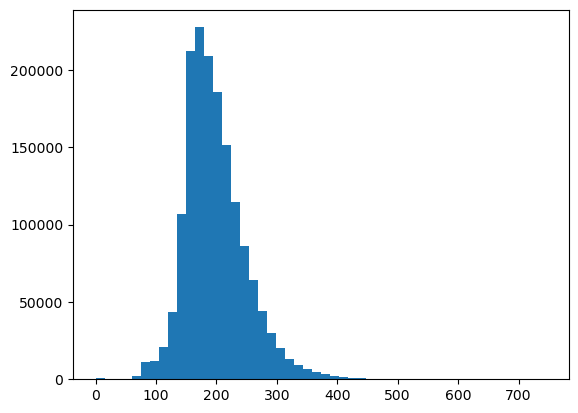

In [7]:
plt.hist(pitch_list, bins=50)

In [8]:
energy_list = []
for x in tqdm(glob(energy_path), total=len(glob(energy_path)), desc="tota:> "):
    energy = np.load(x)
#     print(pitch)
    energy = energy * stats["energy"][3] + stats["energy"][2]
    
    energy_list.extend(energy)
#     print(pitch)
#     break

tota:> :   0%|          | 0/39960 [00:00<?, ?it/s]

(array([1.69701e+05, 8.61520e+04, 8.76940e+04, 9.06340e+04, 9.39160e+04,
        9.62170e+04, 9.75500e+04, 9.64820e+04, 9.31000e+04, 8.78710e+04,
        8.00310e+04, 7.20990e+04, 6.34020e+04, 5.51600e+04, 4.79010e+04,
        4.11730e+04, 3.53890e+04, 3.02900e+04, 2.65600e+04, 2.30140e+04,
        2.00960e+04, 1.73790e+04, 1.48500e+04, 1.28910e+04, 1.05660e+04,
        8.43200e+03, 6.64700e+03, 5.03300e+03, 3.83700e+03, 2.89100e+03,
        2.14400e+03, 1.66700e+03, 1.28900e+03, 9.45000e+02, 8.27000e+02,
        6.40000e+02, 4.94000e+02, 4.29000e+02, 3.11000e+02, 2.38000e+02,
        1.95000e+02, 1.52000e+02, 1.05000e+02, 7.20000e+01, 4.50000e+01,
        3.10000e+01, 1.40000e+01, 6.00000e+00, 1.00000e+01, 4.00000e+00]),
 array([  0.        ,   6.10360241,  12.20720482,  18.31080627,
         24.41440964,  30.51801109,  36.62161255,  42.72521591,
         48.82881927,  54.93241882,  61.03602219,  67.13962555,
         73.2432251 ,  79.34683228,  85.45043182,  91.55403137,
         97.

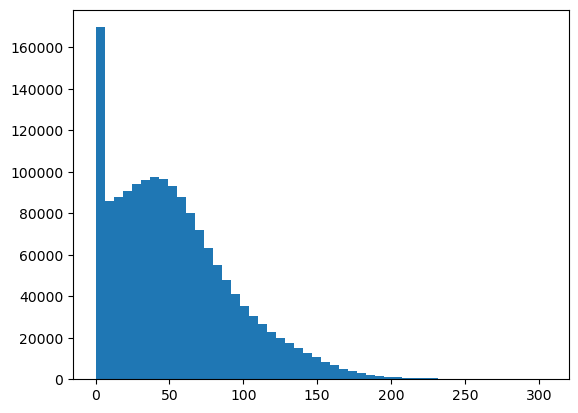

In [9]:
plt.hist(energy_list, bins=50)

In [10]:
duration_list = []
for x in tqdm(glob(duration_path), total=len(glob(duration_path)), desc="tota:> "):
    duration = np.load(x)
#     print(pitch)
    
    duration_list.extend(duration)
#     print(pitch)
#     break

tota:> :   0%|          | 0/39960 [00:00<?, ?it/s]

In [11]:
def remove_outlier(values):
    values = np.array(values)
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
    lower = p25 - 1.75 * (p75 - p25)
    upper = p75 + 1.75 * (p75 - p25)
    normal_indices = np.logical_and(values > lower, values < upper)
    
    return values[normal_indices]

In [12]:
clean_duration_list = remove_outlier(duration_list)

(array([   611.,      0.,      0.,   4566.,      0.,      0.,      0.,
         32501.,      0.,      0.,      0., 131709.,      0.,      0.,
             0., 214711.,      0.,      0.,      0., 243701.,      0.,
             0.,      0., 245243.,      0.,      0., 181374.,      0.,
             0.,      0., 135526.,      0.,      0.,      0., 104266.,
             0.,      0.,      0.,  76490.,      0.,      0.,      0.,
         56476.,      0.,      0.,      0.,  42308.,      0.,      0.,
         29134.]),
 array([ 0.  ,  0.26,  0.52,  0.78,  1.04,  1.3 ,  1.56,  1.82,  2.08,
         2.34,  2.6 ,  2.86,  3.12,  3.38,  3.64,  3.9 ,  4.16,  4.42,
         4.68,  4.94,  5.2 ,  5.46,  5.72,  5.98,  6.24,  6.5 ,  6.76,
         7.02,  7.28,  7.54,  7.8 ,  8.06,  8.32,  8.58,  8.84,  9.1 ,
         9.36,  9.62,  9.88, 10.14, 10.4 , 10.66, 10.92, 11.18, 11.44,
        11.7 , 11.96, 12.22, 12.48, 12.74, 13.  ]),
 <BarContainer object of 50 artists>)

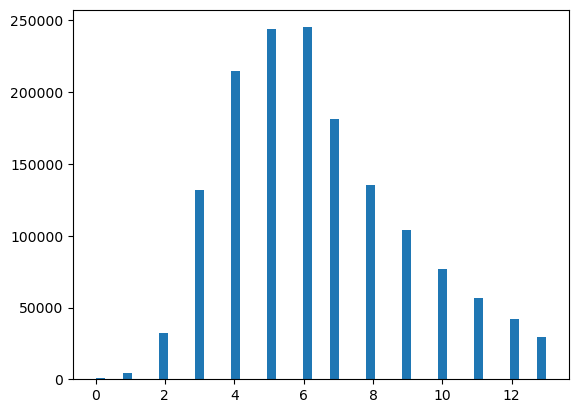

In [13]:
plt.hist(clean_duration_list, bins=50)

In [14]:
import re
from tqdm.notebook import tqdm
import argparse
from string import punctuation

import torch
import yaml
import numpy as np
from torch.utils.data import DataLoader
from g2p_en import G2p
from pypinyin import pinyin, Style

from utils.model import get_model, get_vocoder
from utils.tools import to_device, synth_samples
from dataset import TextDataset
from text import text_to_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [15]:

def read_lexicon(lex_path):
    lexicon = {}
    with open(lex_path) as f:
        for line in f:
            temp = re.split(r"\s+", line.strip("\n"))
            word = temp[0]
            phones = temp[1:]
            if word.lower() not in lexicon:
                lexicon[word.lower()] = phones
    return lexicon


def preprocess_english(text, preprocess_config):
    text = text.rstrip(punctuation)
    lexicon = read_lexicon(preprocess_config["path"]["lexicon_path"])

    g2p = G2p()
    phones = []
    words = re.split(r"([,;.\-\?\!\s+])", text)
    for w in words:
        if w.lower() in lexicon:
            phones += lexicon[w.lower()]
        else:
            phones += list(filter(lambda p: p != " ", g2p(w)))
    phones = "{" + "}{".join(phones) + "}"
    phones = re.sub(r"\{[^\w\s]?\}", "{sp}", phones)
    phones = phones.replace("}{", " ")

    print("Raw Text Sequence: {}".format(text))
    print("Phoneme Sequence: {}".format(phones))
    sequence = np.array(
        text_to_sequence(
            phones, preprocess_config["preprocessing"]["text"]["text_cleaners"]
        )
    )

    return np.array(sequence)


def preprocess_mandarin(text, preprocess_config):
    lexicon = read_lexicon(preprocess_config["path"]["lexicon_path"])

    phones = []
    pinyins = [
        p[0]
        for p in pinyin(
            text, style=Style.TONE3, strict=False, neutral_tone_with_five=True
        )
    ]
    for p in pinyins:
        if p in lexicon:
            phones += lexicon[p]
        else:
            phones.append("sp")

    phones = "{" + " ".join(phones) + "}"
    print("Raw Text Sequence: {}".format(text))
    print("Phoneme Sequence: {}".format(phones))
    sequence = np.array(
        text_to_sequence(
            phones, preprocess_config["preprocessing"]["text"]["text_cleaners"]
        )
    )

    return np.array(sequence)



In [ ]:

def synthesize(model, step, configs, vocoder, batchs, control_values):
    preprocess_config, model_config, train_config = configs
    pitch_control, energy_control, duration_control = control_values

    for batch in tqdm(batchs, total=len(batchs), desc="batches:> "):
        batch = to_device(batch, device)
        with torch.no_grad():
            # Forward
            output = model(
                *(batch[2:]),
                p_control=pitch_control,
                e_control=energy_control,
                d_control=duration_control
            )
            
            pitch = output[1]
            energy = output[2]
            duration = output[4]
            
        
#             synth_samples(
#                 batch,
#                 output,
#                 vocoder,
#                 model_config,
#                 preprocess_config,
#                 train_config["path"]["result_path"],
#             )

In [125]:
class Args:
    mode = "batch"
    source = "/scratch/space1/tc046/lordzuko/work/data/preprocessed_data/BC2013/val.txt"
    restore_step = 10000
    preprocess_config = "config/BC2013/preprocess.yaml"
    model_config = "config/BC2013/model.yaml"
    train_config = "config/BC2013/train.yaml"
    pitch_control = 1.0
    energy_control = 1.0
    duration_control = 1.0

In [126]:
args = Args()

In [127]:
# Read Config
preprocess_config = yaml.load(
    open(args.preprocess_config, "r"), Loader=yaml.FullLoader
)
model_config = yaml.load(open(args.model_config, "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open(args.train_config, "r"), Loader=yaml.FullLoader)
configs = (preprocess_config, model_config, train_config)

In [128]:
# Get model
print("Loading Model...")
model = get_model(args, configs, device, train=False)
print("Model Loaded")
# Load vocoder
print("Loading Vocoder...")
vocoder = get_vocoder(model_config, device)
print("Vocoder Loaded")


Loading Model...
Model Loaded
Loading Vocoder...
Removing weight norm...
Vocoder Loaded


In [129]:
# Get dataset
dataset = TextDataset(args.source, preprocess_config)
batchs = DataLoader(
    dataset,
    batch_size=8,
    collate_fn=dataset.collate_fn,
)

In [130]:
control_values = args.pitch_control, args.energy_control, args.duration_control   

In [131]:
pitch_control, energy_control, duration_control = control_values

In [132]:
pred_pitch_list = []
pred_energy_list = []
pred_duration_list = []

for batch in tqdm(batchs, total=len(batchs), desc="batches:> "):
    batch = to_device(batch, device)
    with torch.no_grad():
        # Forward
        output = model(
            *(batch[2:]),
            p_control=pitch_control,
            e_control=energy_control,
            d_control=duration_control
        )

        pitch = output[2]
        energy = output[3]
        duration = output[5]
        src_mask = output[6]
        
        
        for p,e,d, m in zip(pitch, energy, duration, src_mask):
            pred_pitch_list.extend(list(p[~m].cpu().numpy()))
            pred_energy_list.extend(list(e[~m].cpu().numpy()))
            pred_duration_list.extend(list(d[~m].cpu().numpy()))


batches:> :   0%|          | 0/64 [00:00<?, ?it/s]

In [133]:
pred_np_pitch = np.array(pred_pitch_list) * stats["pitch"][3] + stats["pitch"][2]
pred_np_energy = np.array(pred_energy_list) * stats["energy"][3] + stats["energy"][2]

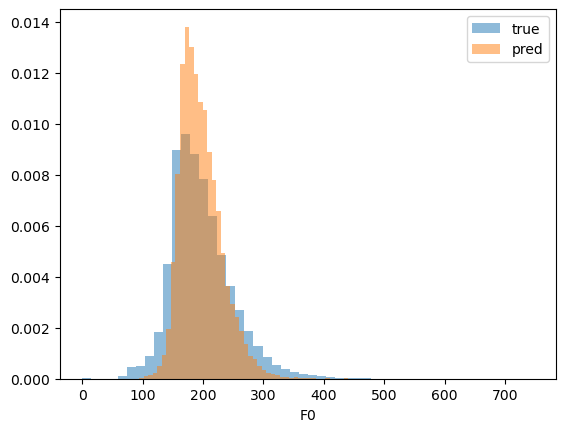

In [134]:
%matplotlib inline

plt.hist(pitch_list, bins=50, alpha=0.5, label='true', density=True)
plt.hist(list(pred_np_pitch), bins=50, alpha=0.5, label='pred', density=True)
plt.legend(loc='upper right')
plt.xlabel("F0")
plt.show()

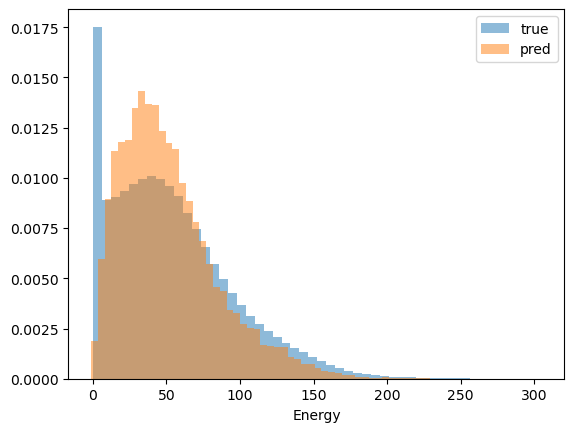

In [135]:
%matplotlib inline

plt.hist(energy_list, bins=50, alpha=0.5, label='true', density=True)
plt.hist(list(pred_np_energy), bins=50, alpha=0.5, label='pred', density=True)
plt.legend(loc='upper right')
plt.xlabel("Energy")
plt.show()

In [136]:
clean_pred_duration_list = remove_outlier(pred_duration_list)

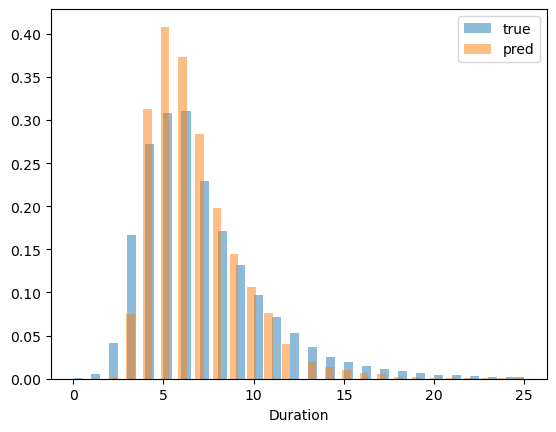

In [137]:
%matplotlib inline

plt.hist(clean_duration_list, bins=50, alpha=0.5, label='true', density=True)
plt.hist(list(clean_pred_duration_list), bins=50, alpha=0.5, label='pred', density=True)
plt.legend(loc='upper right')
plt.xlabel("Duration")
plt.show()

In [138]:
def remove_outlier(values):
    values = np.array(values)
    p25 = np.percentile(values, 25)
    p75 = np.percentile(values, 75)
    lower = p25 - 6 * (p75 - p25)
    upper = p75 + 6 * (p75 - p25)
    normal_indices = np.logical_and(values > lower, values < upper)
    
    return values[normal_indices]

In [139]:
clean_duration_list = remove_outlier(duration_list)
clean_pred_duration_list = remove_outlier(pred_duration_list)

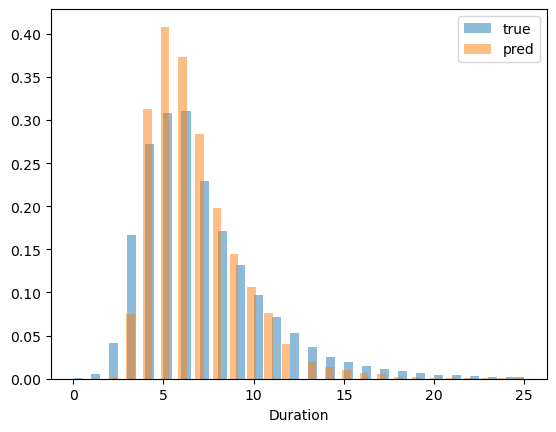

In [140]:
%matplotlib inline

plt.hist(clean_duration_list, bins=50, alpha=0.5, label='true', density=True)
plt.hist(list(clean_pred_duration_list), bins=50, alpha=0.5, label='pred', density=True)
plt.legend(loc='upper right')
plt.xlabel("Duration")
plt.show()